# Experiment 3
Input data: DAiSEE features extracted using MEDIAPIPE in CSV files
(Step 0) Data preparation:
* [Case 1] Average all frames into 1 timesteps

Step 1: Load data and preprocess (for case 1)

Step 2: Build models, compile, and train. 

Step 3: Evaluation

* Performance comparation between LSTM, CNN, and Classical Machine Learning Model

Check EDA repository to understand how the data were extracted and prepared 
https://github.com/shofi777/EDA.git

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pickle

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential #, Input
from tensorflow.keras.layers import *
# from keras.layers import Attention
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, fbeta_score, auc, roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline
# %matplotlib notebook

# 1. Load Data and Pre-process

In [2]:
#load data
def load_data(datafile):
    df = pd.read_csv(datafile)
    df = df.drop(df.columns[0], axis=1)
    return df

#Split features and label
def split_label(df):
    df = np.array(df)
    Y = df[:,-1]
    print('Y original =', Y)
    Y = np.where(Y==1, 0, Y) #combine label 0 and 1
    Y = np.where(Y==2, 1, Y) #change label 2 to 1
    Y = np.where(Y==3, 2, Y) #change label 3 to 2
    print('Y before encode =', Y)
    Y = LabelEncoder().fit_transform(Y) #encode label value as label variable
    print('Y after encode =', Y)
    X = df[:,0:-1]    
    return X, Y

#Resampling
def resample(label0,label1,label2,X,Y):
    #downsampling
    strategydown = {0:label0, 1:label1, 2:label2} 
    downsample = RandomUnderSampler(sampling_strategy=strategydown) 
    X_resampled, Y_resampled = downsample.fit_resample(X, Y) #fit and apply transform
    
    #oversampling
    oversample = SMOTE()#sampling_strategy='not minority'
    X_resampled, Y_resampled = oversample.fit_resample(X_resampled, Y_resampled) #fit and apply transform
    return X_resampled, Y_resampled 

# Normalization and dimensionality reduction
def norm(X):     
    # normalize the range features
    scaler = MinMaxScaler(feature_range=(0,1))  #.fit(X_train_av)
    X = scaler.fit_transform(X)

    # PCA decomposition. Set components number from 329(original) to 200 (to 1500 for daisee_mediapipe data)
    # pca = decomposition.PCA(n_components=1500) #.fit(X_train_av)
    # X = pca.fit_transform(X)
    
    return X #, X_inverted

#reshape to 3D data (nsample,ntimestep,nfeatures)
def reshaping(X):
    X = X.reshape(X.shape[0],1,X.shape[1]) 
    return X

## [Case 1] Averaged data input

In [3]:
df_train_av = load_data('dataset/average_train_mediapipe.csv')
df_val_av = load_data('dataset/average_val_mediapipe.csv')
df_test_av = load_data('dataset/average_test_mediapipe.csv')
print('Train = ', df_train_av.shape)
print('Val = ', df_val_av.shape)
print('Test = ', df_test_av.shape)

Train =  (5467, 2005)
Val =  (1703, 2005)
Test =  (1784, 2005)


In [4]:
#Concatenate train and validation set
df_train_concat = pd.concat([df_train_av,df_val_av], axis=0, ignore_index=True)
df_all_concat = pd.concat([df_train_concat,df_test_av], axis=0, ignore_index=True)
print(df_all_concat.shape)
print(df_train_concat.shape)

(8954, 2005)
(7170, 2005)


In [5]:
## Check for NULL
print(df_train_concat.isna().sum().sum())
print(df_train_concat.isnull().sum().sum())
# print(np.all(np.isfinite(df_all_concat)))

2004
2004


In [6]:
# If NaN exist, use imputation
imp = SimpleImputer(strategy='median')
df_train_concat = pd.DataFrame(imp.fit_transform(df_train_concat))
df_all_concat = pd.DataFrame(imp.fit_transform(df_all_concat))
df_test_av = pd.DataFrame(imp.fit_transform(df_test_av))
print(df_train_concat.isna().sum().sum())
print(df_train_concat.isnull().sum().sum())

0
0


In [7]:
X_train_all, Y_train_all = split_label(df_all_concat)
X_train_av, Y_train_av = split_label(df_train_concat)
# X_train_av, Y_train_av = split_label(df_train_av)
X_val_av, Y_val_av = split_label(df_val_av)
X_test_av, Y_test_av = split_label(df_test_av)

Y original = [2. 2. 3. ... 3. 3. 2.]
Y before encode = [1. 1. 2. ... 2. 2. 1.]
Y after encode = [1 1 2 ... 2 2 1]
Y original = [2. 2. 3. ... 2. 3. 2.]
Y before encode = [1. 1. 2. ... 1. 2. 1.]
Y after encode = [1 1 2 ... 1 2 1]
Y original = [2. 3. 2. ... 2. 3. 2.]
Y before encode = [1. 2. 1. ... 1. 2. 1.]
Y after encode = [1 2 1 ... 1 2 1]
Y original = [2. 2. 2. ... 3. 3. 2.]
Y before encode = [1. 1. 1. ... 2. 2. 1.]
Y after encode = [1 1 1 ... 2 2 1]


Train + Validation set:
Engagement=1, n=3554 (49.568%)
Engagement=2, n=3185 (44.421%)
Engagement=0, n=431 (6.011%)
Total= 7170

Validation-only set:
Engagement=1, n=911 (53.494%)
Engagement=2, n=609 (35.760%)
Engagement=0, n=183 (10.746%)
Total= 1703

Test set:
Engagement=1, n=882 (49.439%)
Engagement=2, n=814 (45.628%)
Engagement=0, n=88 (4.933%)
Total= 1784
[1, 2, 0]
[3554, 3185, 431]


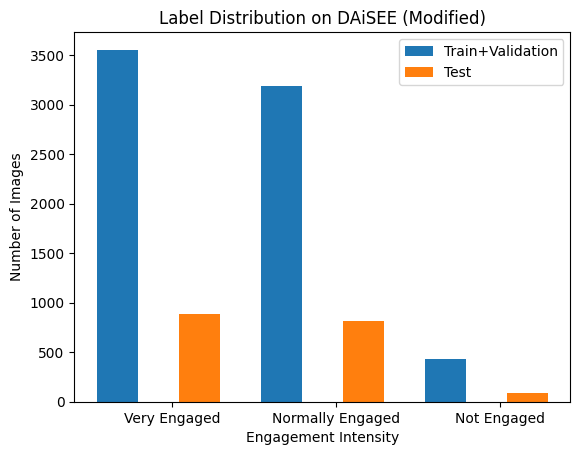

In [8]:
#Plot Distribution after concatenation train+validation
def plot_dist(Y):
    counter = Counter(Y)
    key =[]
    value = []
    for k,v in counter.items():
        per = v / len(Y)*100
        print('Engagement=%d, n=%d (%.3f%%)' % (k,v,per))
        key.append(k)
        value.append(v)
    print('Total=', len(Y))
    return key, value

print("Train + Validation set:")
k_train, v_train = plot_dist(Y_train_av)
print("\nValidation-only set:")
k_val, v_val = plot_dist(Y_val_av)
print("\nTest set:")
k_test, v_test = plot_dist(Y_test_av)
print(k_train)
print(v_train)

#Plot the distribution
ind = np.arange(len(k_train)) 
w = 0.25 
plt.bar(ind  , v_train, width=w, label='Train+Validation')
# plt.bar(ind + w, v_val, width=w, label='Validation')
plt.bar(ind + w + w, v_test, width=w,label='Test')

plt.ylabel('Number of Images')
plt.xlabel('Engagement Intensity')
plt.title('Label Distribution on DAiSEE (Modified)')
plt.xticks(ind + w + w/ 3, ('Very Engaged','Normally Engaged','Not Engaged'))

# plt.title('Engagement Label Distributions on DAiSEE')
# plt.xticks(ind + 0.08 + 0.08 + 0.08, ('3\nVery High','2\nHigh','1\nLow','0\nVery Low'))
plt.legend(loc='best')
plt.show()

In [9]:
X_train_all, Y_train_all = resample(501,2000,2000,X_train_all,Y_train_all) #413,1472,1715
X_train_av, Y_train_av = resample(413,1000,1000,X_train_av,Y_train_av) #247,1000,1000
X_val_av, Y_val_av = resample(166,200,200,X_val_av,Y_val_av)
X_test_av, Y_test_av = resample(88,441,407,X_test_av,Y_test_av)

In [10]:
X_train_all_norm = norm(X_train_all)
X_train = norm(X_train_av)
X_val_av_norm = norm(X_val_av)
X_test_av_norm = norm(X_test_av)
# print('X training=',X_train.shape)
# # print('X val=',X_val.shape)
# print('X test=',X_test.shape)
X_train_av = X_train

In [11]:
X_train_all = reshaping(X_train_all_norm)
X_train_av = reshaping(X_train_av)
X_val_av = reshaping(X_val_av_norm)
X_test_av = reshaping(X_test_av_norm) 
print('X_train_all:{} | Y_train_all:{}\nX_train_av:{} | Y_train_av:{}\nX_test_av:{} | Y_test_av:{} '.format(X_train_all.shape, Y_train_all.shape, X_train_av.shape, Y_train_av.shape, X_test_av.shape, Y_test_av.shape))

X_train_all:(6000, 1, 2004) | Y_train_all:(6000,)
X_train_av:(3000, 1, 2004) | Y_train_av:(3000,)
X_test_av:(1323, 1, 2004) | Y_test_av:(1323,) 


In [12]:
Y_train_cat_all = to_categorical(Y_train_all)
Y_train_cat_av = to_categorical(Y_train_av) #convert label vector to one-hot matrix
Y_val_cat_av = to_categorical(Y_val_av) #convert label vector to one-hot matrix
Y_test_cat_av = to_categorical(Y_test_av) 
print('Y after convert to 1hot =', Y_train_cat_av)
print(Y_train_cat_av.shape)

Y after convert to 1hot = [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(3000, 3)


# 2. Build Models, Compile and Train

In [13]:
# CNN
def CNN(X):
    # Initialising the CNN
    model = Sequential()

    ## 4 conv net layers, 3 dense layers (2 fully connected, 1 softmax) 
    # 1 - Convolution
    model.add(Conv1D(64,3, padding='same', input_shape=((X.shape[1],X.shape[2]))))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(MaxPooling1D(pool_size=2)) #downsampling/ shrink the height and width dimension by factor of 2  
   
    # 2nd Convolution layer
    model.add(Conv1D(128,5, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=2))

    # 3rd Convolution layer
    model.add(Conv1D(512,3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=2))

    # 4th Convolution layer
    model.add(Conv1D(512,3, padding='same'))#
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    # Fully connected layer 3nd layer
    model.add(Dense(512, name = 'convy'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(3, activation='softmax'))

    model.get_layer('convy').kernel_regularizer = regularizers.l2(0.0001)
    model._name='CNNmodel'
    model.summary()

    return model

In [14]:
# LSTM
# ## 1. Vanila LSTM
# - Memory cells of a single LSTM layer are used in a simple network structure
def vanilaLSTM(X):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1],X.shape[2]))) #use average data
    model.add(Dense(3, activation='softmax'))
    model._name='vanilaLSTM'
    print(model.summary())
    return model

# ## 2. Stacked LSTM
# - LSTM layers are stacked one on top of another into deep recurrent neural networks
def stackedLSTM(X):
    model = Sequential()
    model.add(LSTM(75, activation='relu', return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
    model.add(LSTM(75, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='stackedLSTM'
    print(model.summary())
    return model

# ## 3. Bi-LSTM
# - Input sequences are presented and learned both forward and backward
def biLSTM(X):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(3, activation='softmax'))
    model._name='biLSTM'
    print(model.summary())
    return model

# ## 4. BiLSTM (Ensamble)
# - Follow An Ensemble model using face and body tracking for engagement detection
def bilstm_en(X):
    model = Sequential()
    model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
    model.add(Dense(16))
    model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    # model.add(Dropout(0.5))
    # modelD.add(GlobalAveragePooling1D())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='bilstm_en'
    print(model.summary())
    return model

In [15]:
# CNN
CNN_model = CNN(X_train_av)

#instantiate the model[Case 1]
vanilaLSTM_model = vanilaLSTM(X_train_av)
stackedLSTM_model = stackedLSTM(X_train_av)
biLSTM_model = biLSTM(X_train_av)
bilstm_en_model = bilstm_en(X_train_av)

Model: "CNNmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             384832    
                                                                 
 batch_normalization (BatchN  (None, 1, 64)            256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 activation_1 (Activation)   (None, 1, 128)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 128)           512       
 hNormalization)                                          

In [16]:
# #instantiate the model [Case 2]
# vanilaLSTM_model = vanilaLSTM(X_train)
# stackedLSTM_model = stackedLSTM(X_train)
# biLSTM_model = biLSTM(X_train)
# bilstm_en_model = bilstm_en(X_train)

### Fit Models and Evaluation

In [17]:
#compile and train model
def compile_train(model,Xtrain,YtrainCat):
    loss = 'categorical_crossentropy' # mse 'sparse_categorical_crossentropy'
    metrics = ['categorical_accuracy'] 
    monitor= 'val_loss' 
    lr=1e-3

    #learning rate schedule: reduce learning rate 0.1 every 2 epochs 
    reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=2, min_lr=0.00001, mode='auto')
    es = EarlyStopping(monitor=monitor, min_delta=0.0001, patience=50)

    model.compile(loss=loss, optimizer=Adam(learning_rate=lr), metrics=metrics)  
    filepath = 'weights/' + model.name + '_mediapipe.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1,
                                 save_weights_only=True, save_best_only=True,
                                 mode='auto')
    history = model.fit(Xtrain,YtrainCat, epochs=500, verbose=1,
                        callbacks = [PlotLossesCallback(), checkpoint, es],# ,reduce_lr
                        batch_size = 32,
                        validation_split=0.2, 
                        # validation_data=(X_test_av, Y_test_cat_av), 
                        # validation_data=(X_val_av, Y_val_cat_av), 
                        shuffle=True
                        # class_weight = 'balanced'
                       )
    
    weight_file = model.save(filepath)
    # mse, acc = model.evaluate(X_train, YtrainCat, verbose=0)
    return history, weight_file

def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    acc = accuracy_score(Ytest, pred) #accuracy
    f1 = f1_score(Ytest, pred, average='macro')
    fbeta = fbeta_score(Ytest, pred, average='macro', beta=4)
    auc = roc_auc_score(Ytest, trainedmodel.predict(Xtest), average='macro', multi_class='ovr')
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error,
        '\n MSE = ',mse,
        '\n Accuracy = ',acc,
        '\n AUC = ', auc,
        '\n F1-score = ',f1,
        '\n Fbeta = ',fbeta
        )

    #  Plotting confusion matrix
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    cm = pd.DataFrame(cm,range(3),range(3))

    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    return 

#### Logistic Regression

In [18]:
# Fit multiclass Logistic Regression model
tic = datetime.now()

lr = LogisticRegression(C=1, multi_class='multinomial', max_iter=1000).fit(X_train, Y_train_av)
time = datetime.now() - tic

print("Training time single training:{}".format(time))

print("Training set score: %f" % lr.score(X_train,Y_train_av))
print("Test set score: %f" % lr.score(X_test_av_norm, Y_test_av))
print("Coefficients shape: ", lr.coef_.shape)
print("Intercept shape: ", lr.intercept_.shape)

# Kfold cross validation
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)
tic = datetime.now()
n_scores = cross_val_score(lr, X_train_all_norm, Y_train_all,scoring='accuracy', cv=skf, n_jobs=1)
time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time single training:0:00:05.030000
Training set score: 0.530000
Test set score: 0.338624
Coefficients shape:  (3, 2004)
Intercept shape:  (3,)


c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Training time for 5-fold cv:0:00:37.225998
Mean Accuracy 5-fold cv: 0.498 (0.007)


c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### CNN

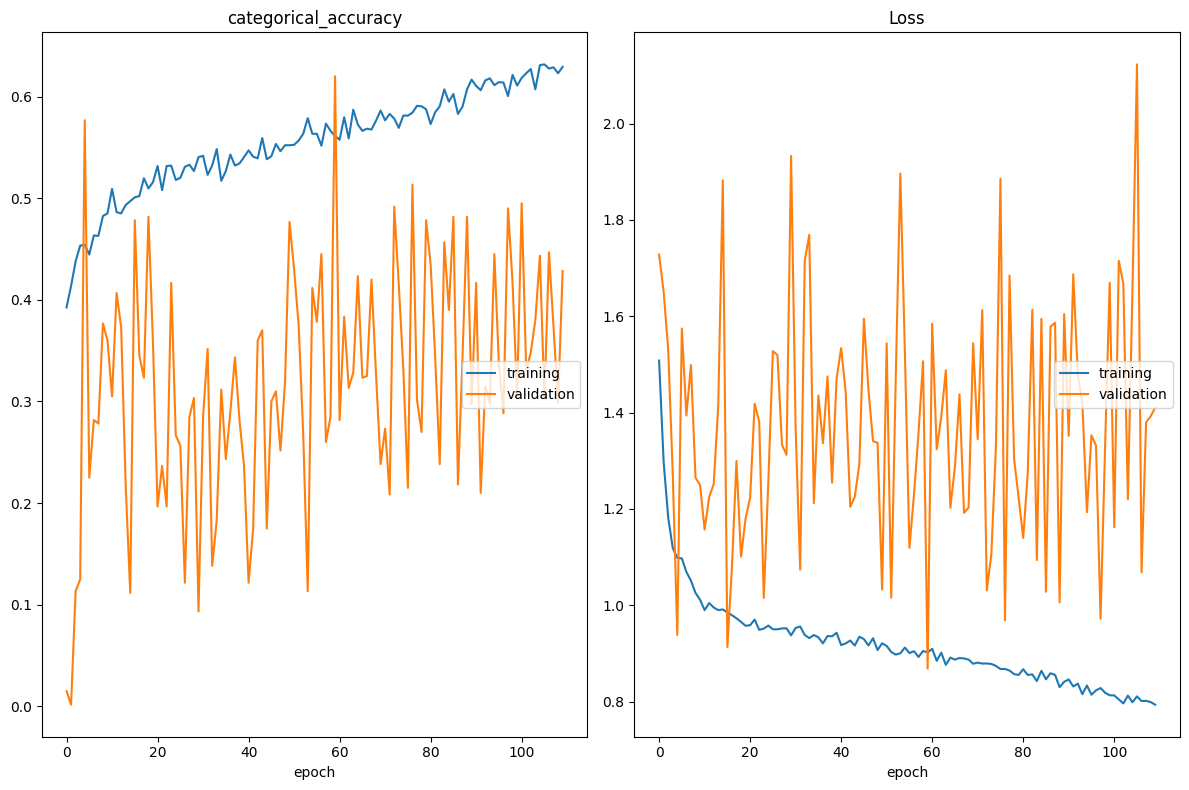

categorical_accuracy
	training         	 (min:    0.393, max:    0.632, cur:    0.629)
	validation       	 (min:    0.002, max:    0.620, cur:    0.428)
Loss
	training         	 (min:    0.793, max:    1.508, cur:    0.793)
	validation       	 (min:    0.868, max:    2.123, cur:    1.410)

Epoch 110: val_loss did not improve from 0.86817
75/75 [==============================] - 1s 11ms/step - loss: 0.7934 - categorical_accuracy: 0.6292 - val_loss: 1.4104 - val_categorical_accuracy: 0.4283
Training time:0:01:27.103849
42/42 [==============================] - 0s 4ms/step - loss: 1.7843 - categorical_accuracy: 0.3590
Accuracy on Test set: 35.90%
42/42 [==============================] - 0s 2ms/step
|CNNmodel|
 Error rate = 0.6409674981103552 
 MSE =  1.0037792894935753 
 Accuracy =  0.35903250188964475 
 AUC =  0.5347313276532583 
 F1-score =  0.3252190756221693 
 Fbeta =  0.35114367803736696
None


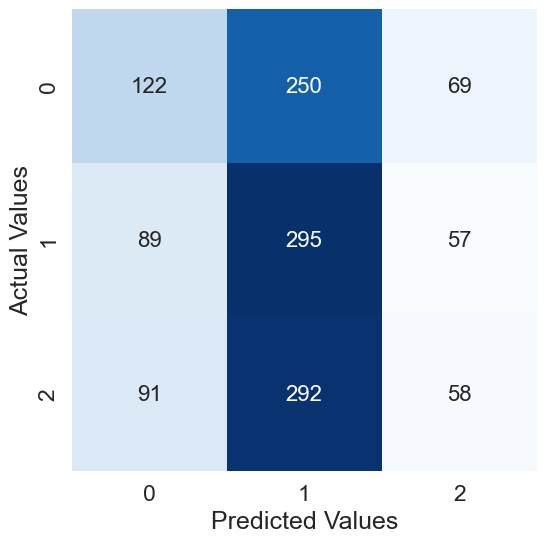

In [19]:
tic = datetime.now()
compile_train(CNN_model,X_train_av,Y_train_cat_av)  # [case 1] classification
# compile_train(vanilaLSTM_model,X_train_av,Y_train_av)  # [case 1] regression
# compile_train(vanilaLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = CNN_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(CNN_model,X_test_av, Y_test_av))


#### SingleLSTM

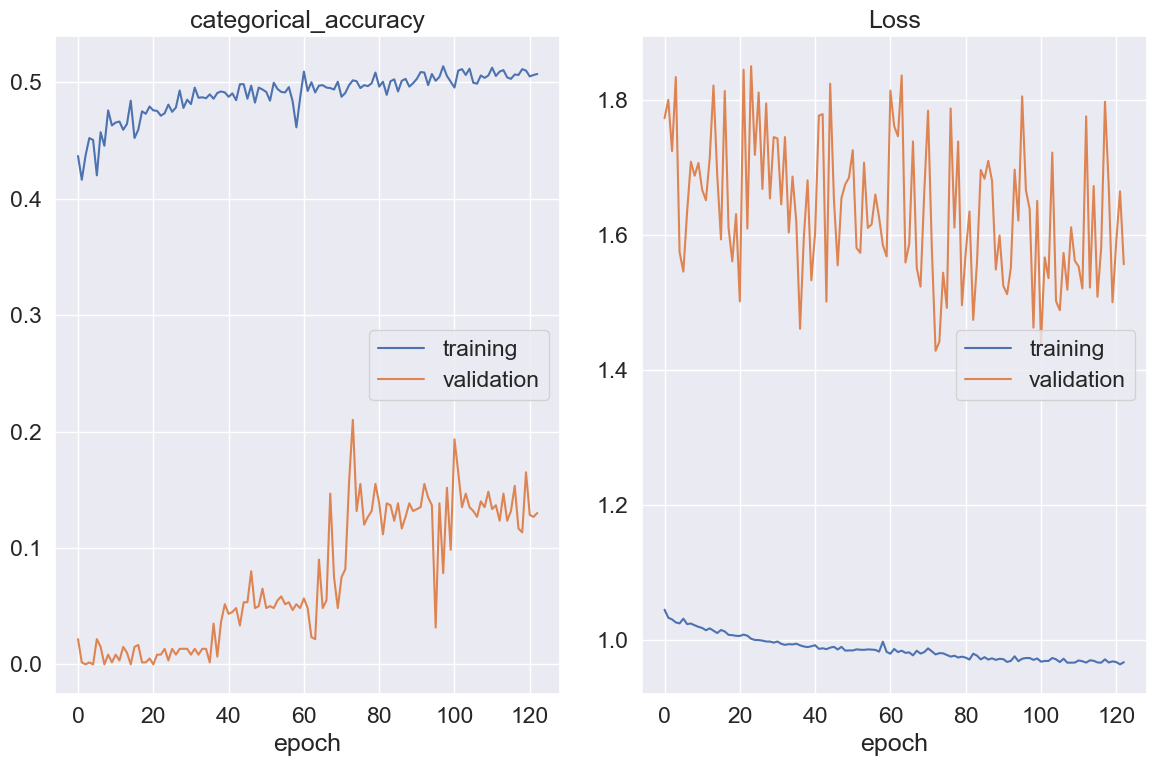

categorical_accuracy
	training         	 (min:    0.416, max:    0.514, cur:    0.507)
	validation       	 (min:    0.000, max:    0.210, cur:    0.130)
Loss
	training         	 (min:    0.963, max:    1.044, cur:    0.966)
	validation       	 (min:    1.428, max:    1.850, cur:    1.556)

Epoch 123: val_loss did not improve from 1.42819
75/75 [==============================] - 1s 7ms/step - loss: 0.9665 - categorical_accuracy: 0.5071 - val_loss: 1.5565 - val_categorical_accuracy: 0.1300
Training time:0:01:01.574320
42/42 [==============================] - 0s 2ms/step - loss: 1.1701 - categorical_accuracy: 0.3318
Accuracy on Test set: 33.18%
42/42 [==============================] - 0s 1ms/step
|vanilaLSTM|
 Error rate = 0.6681783824640968 
 MSE =  0.8405139833711263 
 Accuracy =  0.3318216175359032 
 AUC =  0.574644823915961 
 F1-score =  0.247701064866676 
 Fbeta =  0.3145670185020117
None


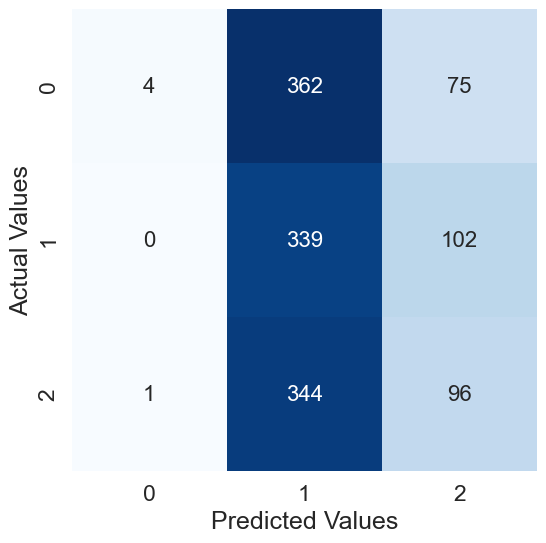

In [20]:
tic = datetime.now()
compile_train(vanilaLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] classification
# compile_train(vanilaLSTM_model,X_train_av,Y_train_av)  # [case 1] regression
# compile_train(vanilaLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(vanilaLSTM_model,X_test_av, Y_test_av))

#### StackedLSTM

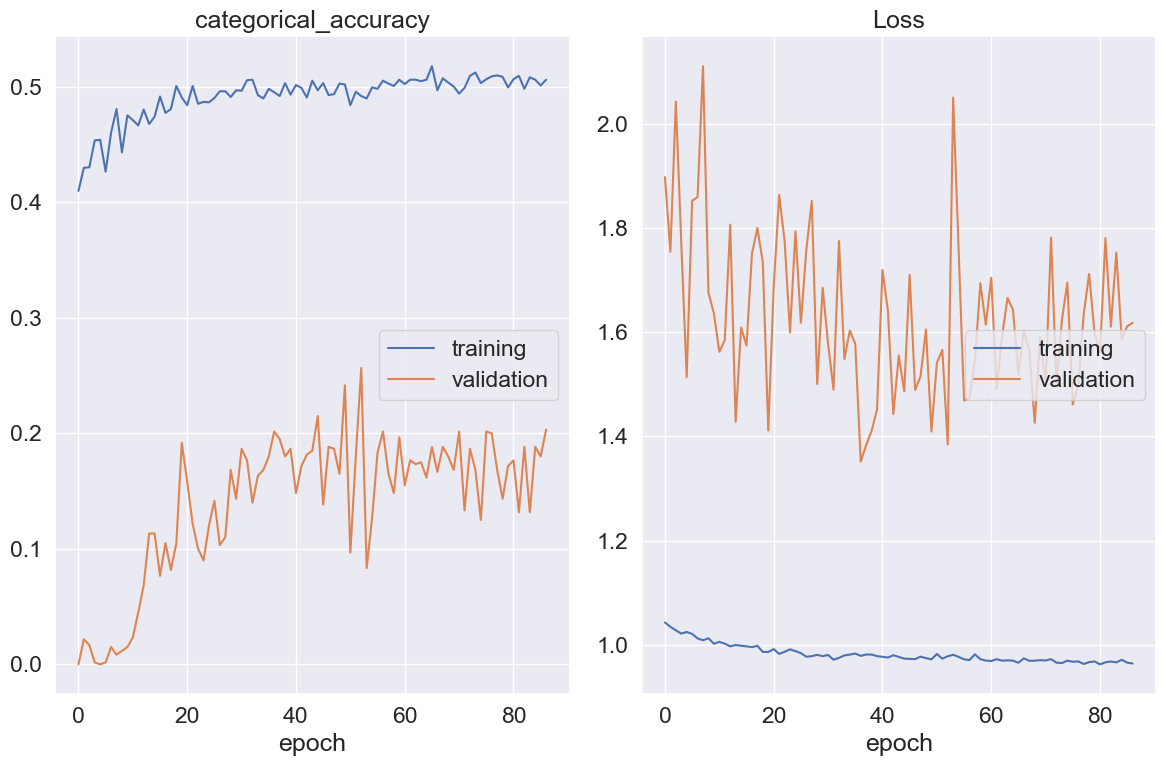

categorical_accuracy
	training         	 (min:    0.410, max:    0.518, cur:    0.506)
	validation       	 (min:    0.000, max:    0.257, cur:    0.203)
Loss
	training         	 (min:    0.963, max:    1.043, cur:    0.964)
	validation       	 (min:    1.352, max:    2.110, cur:    1.618)

Epoch 87: val_loss did not improve from 1.35165
75/75 [==============================] - 1s 8ms/step - loss: 0.9643 - categorical_accuracy: 0.5063 - val_loss: 1.6181 - val_categorical_accuracy: 0.2033
Training time:0:00:56.649911
42/42 [==============================] - 0s 2ms/step - loss: 1.2296 - categorical_accuracy: 0.3757
Accuracy on Test set: 37.57%
42/42 [==============================] - 0s 1ms/step
|stackedLSTM|
 Error rate = 0.6243386243386243 
 MSE =  0.871504157218443 
 Accuracy =  0.37566137566137564 
 AUC =  0.5688404865599552 
 F1-score =  0.3363236953089015 
 Fbeta =  0.3654465293805827
None


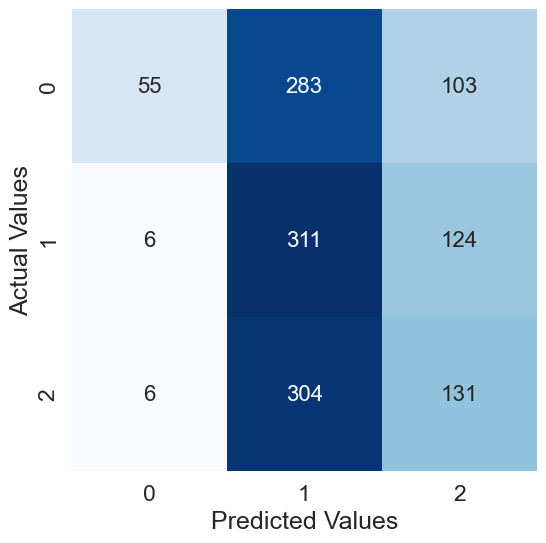

In [21]:
tic = datetime.now()
compile_train(stackedLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(stackedLSTM_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(stackedLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(stackedLSTM_model,X_test_av, Y_test_av))

#### BiLSTM

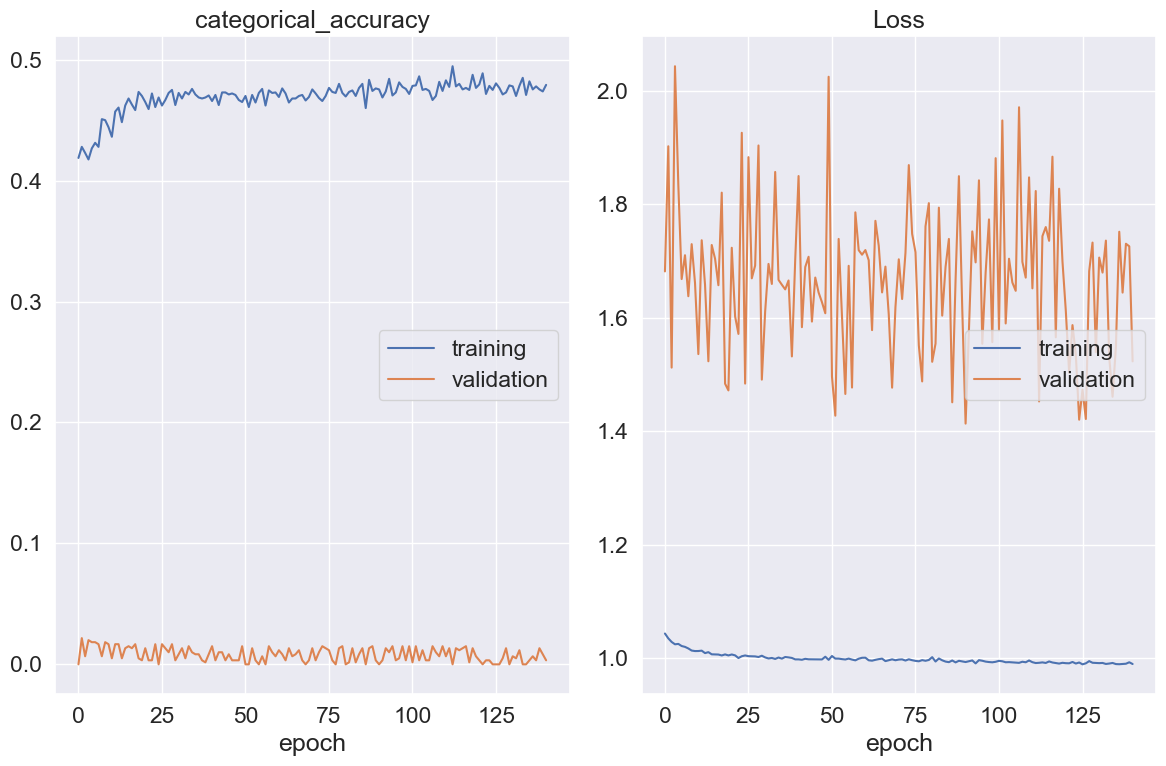

categorical_accuracy
	training         	 (min:    0.417, max:    0.495, cur:    0.479)
	validation       	 (min:    0.000, max:    0.022, cur:    0.003)
Loss
	training         	 (min:    0.989, max:    1.043, cur:    0.990)
	validation       	 (min:    1.414, max:    2.044, cur:    1.523)

Epoch 141: val_loss did not improve from 1.41353
75/75 [==============================] - 1s 8ms/step - loss: 0.9897 - categorical_accuracy: 0.4792 - val_loss: 1.5233 - val_categorical_accuracy: 0.0033
Training time:0:01:21.836336
42/42 [==============================] - 0s 2ms/step - loss: 1.2180 - categorical_accuracy: 0.3167
Accuracy on Test set: 31.67%
42/42 [==============================] - 0s 1ms/step
|biLSTM|
 Error rate = 0.6832955404383976 
 MSE =  1.2501889644746789 
 Accuracy =  0.3167044595616024 
 AUC =  0.5330554998517422 
 F1-score =  0.21742163941080958 
 Fbeta =  0.2985098754344896
None


c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


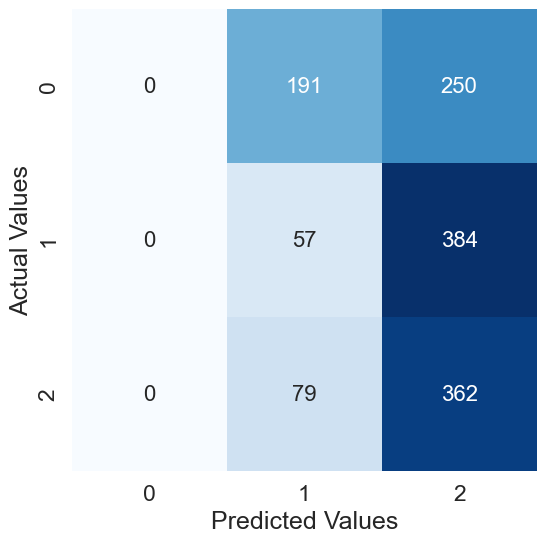

In [22]:
tic = datetime.now()
compile_train(biLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(biLSTM_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(biLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_model,X_test_av, Y_test_av))

#### Multilayer-BiLSTM

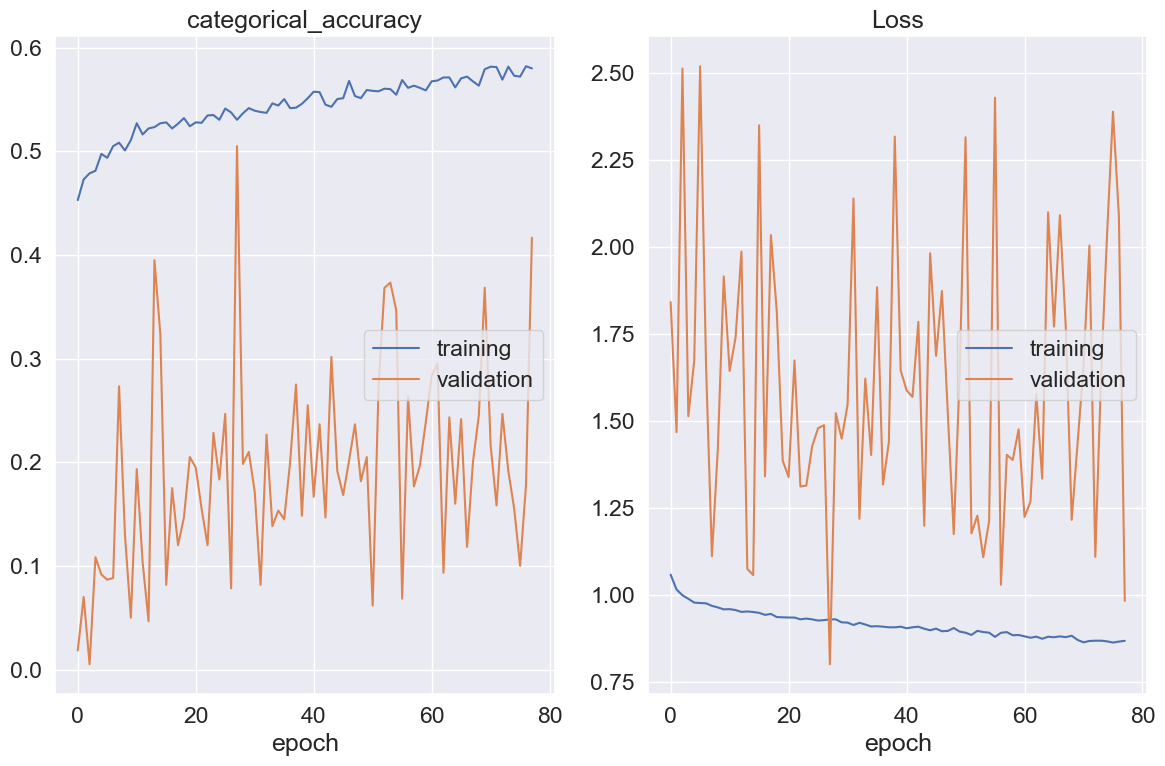

categorical_accuracy
	training         	 (min:    0.453, max:    0.582, cur:    0.580)
	validation       	 (min:    0.005, max:    0.505, cur:    0.417)
Loss
	training         	 (min:    0.863, max:    1.058, cur:    0.868)
	validation       	 (min:    0.800, max:    2.520, cur:    0.982)

Epoch 78: val_loss did not improve from 0.79988
75/75 [==============================] - 1s 9ms/step - loss: 0.8676 - categorical_accuracy: 0.5800 - val_loss: 0.9823 - val_categorical_accuracy: 0.4167
Training time:0:00:57.024029
42/42 [==============================] - 0s 3ms/step - loss: 1.4926 - categorical_accuracy: 0.3333
Accuracy on Test set: 33.33%
42/42 [==============================] - 0s 2ms/step
|bilstm_en|
 Error rate = 0.6666666666666666 
 MSE =  1.0680272108843538 
 Accuracy =  0.3333333333333333 
 AUC =  0.5121022961968864 
 F1-score =  0.2790073069458587 
 Fbeta =  0.3246481884682835
None


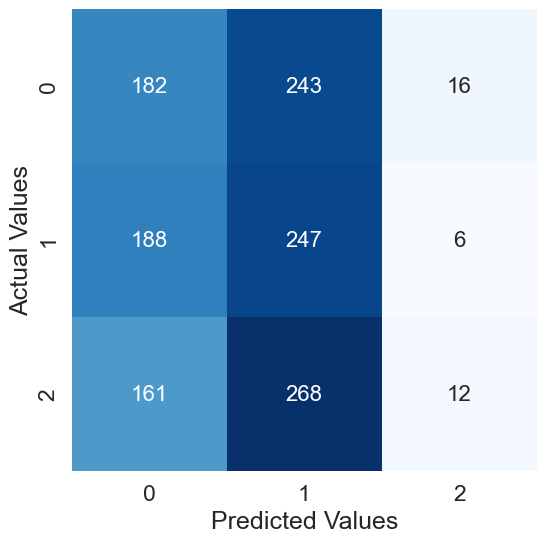

In [23]:
tic = datetime.now()
compile_train(bilstm_en_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(bilstm_en_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(bilstm_en_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = bilstm_en_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(bilstm_en_model,X_test_av, Y_test_av))

## K-Fold Cross Validation

In [24]:
save_dir = '/weights/'
fold_var = 1
#KFold split
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)
cvscores_single = []


#### CNN

In [25]:
cvscores = []
tic = datetime.now()
# for train_index, val_index in enumerate(kf.split(X_train_av,Y_train_cat_av)):
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    # print("TRAIN:", train_index, "TEST:", val_index)
    # X_train, X_test = X_train_all[train_index], X_train_all[val_index]
    # Y_train, Y_test = Y_train_all[train_index], Y_train_all[val_index]
     
    CNN_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])#loss='mse'

    CNN_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = CNN_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    # print("%s: %f" % (CNN_model.metrics_names[0], scores[0]), "%s: %.2f%%" % (CNN_model.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
    
time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 0s - loss: 1.3337 - categorical_accuracy: 0.5425 - 296ms/epoch - 8ms/step
38/38 - 0s - loss: 1.1486 - categorical_accuracy: 0.5792 - 255ms/epoch - 7ms/step
38/38 - 0s - loss: 1.2426 - categorical_accuracy: 0.5533 - 254ms/epoch - 7ms/step
38/38 - 0s - loss: 1.0057 - categorical_accuracy: 0.6642 - 260ms/epoch - 7ms/step
38/38 - 0s - loss: 1.3271 - categorical_accuracy: 0.5817 - 249ms/epoch - 7ms/step
Training time for 5-fold cv:0:11:16.511998
Mean Accuracy 5-fold cv: 0.584 (0.043)


#### SingleLSTM

In [26]:
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    
    vanilaLSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])
    vanilaLSTM_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = vanilaLSTM_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])

time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 0s - loss: 1.0366 - categorical_accuracy: 0.4667 - 330ms/epoch - 9ms/step
38/38 - 0s - loss: 1.0206 - categorical_accuracy: 0.4833 - 331ms/epoch - 9ms/step
38/38 - 0s - loss: 1.0135 - categorical_accuracy: 0.4708 - 332ms/epoch - 9ms/step
38/38 - 0s - loss: 0.9734 - categorical_accuracy: 0.4817 - 332ms/epoch - 9ms/step
38/38 - 0s - loss: 0.9644 - categorical_accuracy: 0.4942 - 326ms/epoch - 9ms/step
Training time for 5-fold cv:0:04:18.084001
Mean Accuracy 5-fold cv: 0.479 (0.010)


#### StackedLSTM

In [27]:
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    
    stackedLSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])#loss='mse'
    stackedLSTM_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = stackedLSTM_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])

time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 0s - loss: 1.0167 - categorical_accuracy: 0.4592 - 281ms/epoch - 7ms/step
38/38 - 0s - loss: 1.0166 - categorical_accuracy: 0.4783 - 276ms/epoch - 7ms/step
38/38 - 0s - loss: 0.9752 - categorical_accuracy: 0.5025 - 290ms/epoch - 8ms/step
38/38 - 0s - loss: 0.9608 - categorical_accuracy: 0.4842 - 285ms/epoch - 7ms/step
38/38 - 0s - loss: 0.9470 - categorical_accuracy: 0.5000 - 276ms/epoch - 7ms/step
Training time for 5-fold cv:0:09:16.484488
Mean Accuracy 5-fold cv: 0.485 (0.016)


#### Bi-LSTM

In [28]:
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    
    biLSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])
    biLSTM_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = biLSTM_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])

time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))


c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 0s - loss: 1.0337 - categorical_accuracy: 0.4475 - 286ms/epoch - 8ms/step
38/38 - 0s - loss: 1.0728 - categorical_accuracy: 0.4142 - 284ms/epoch - 7ms/step
38/38 - 0s - loss: 1.0210 - categorical_accuracy: 0.4708 - 281ms/epoch - 7ms/step
38/38 - 0s - loss: 1.0183 - categorical_accuracy: 0.4517 - 273ms/epoch - 7ms/step
38/38 - 0s - loss: 0.9998 - categorical_accuracy: 0.4708 - 271ms/epoch - 7ms/step
Training time for 5-fold cv:0:06:05.711985
Mean Accuracy 5-fold cv: 0.451 (0.021)


#### Multilayer-BiLSTM

In [29]:
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    bilstm_en_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])

    bilstm_en_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = bilstm_en_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])
    
time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 1s - loss: 0.9884 - categorical_accuracy: 0.5433 - 599ms/epoch - 16ms/step
38/38 - 1s - loss: 1.2694 - categorical_accuracy: 0.5083 - 601ms/epoch - 16ms/step
38/38 - 1s - loss: 1.0530 - categorical_accuracy: 0.5692 - 601ms/epoch - 16ms/step
38/38 - 1s - loss: 0.8270 - categorical_accuracy: 0.6500 - 597ms/epoch - 16ms/step
38/38 - 1s - loss: 1.0703 - categorical_accuracy: 0.5650 - 607ms/epoch - 16ms/step
Training time for 5-fold cv:0:07:49.960300
Mean Accuracy 5-fold cv: 0.567 (0.047)


# Evaluate Model

In [ ]:
# # Compile model to evaluate
# loss = 'categorical_crossentropy' #'mse' #sparse_categorical_crossentropy
# metrics = ['Accuracy','mse'] #['mse'] #
# monitor='val_Accuracy' #loss,Accuracy,mse,val_loss,val_Accuracy,val_mse
# lr=1e-3

# vanilaLSTM_model = vanilaLSTM_model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics) 
# stackedLSTM_model = bilstm_en_model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics) 
# biLSTM_model = biLSTM_model.load_weights('weights/biLSTM.hdf5')
# bilstm_en_model = bilstm_en_model.load_weights('weights/biLSTM_en.hdf5')

In [ ]:
# vanilaLSTM_model.load_weights('weights/vanilaLSTM.hdf5')
# stackedLSTM_model.load_weights('weights/stackedLSTM.hdf5')
# biLSTM_model.load_weights('weights/biLSTM.hdf5')
# bilstm_en_model.load_weights('weights/biLSTM_en.hdf5')

In [30]:
#evaluate the model
def evaluate(trainedmodel,Xtest, Ytest_cat):
    mse, acc = trainedmodel.evaluate(Xtest, Ytest_cat,verbose=1)
    print('|'+ trainedmodel.name + '|\n MSE = ', mse, 
      ', Accuracy = ',acc
     )
    return 
print(evaluate(vanilaLSTM_model,X_test_av, Y_test_cat_av)) #X_test, Y_test, 
print(evaluate(stackedLSTM_model,X_test_av, Y_test_cat_av))
print(evaluate(biLSTM_model,X_test_av, Y_test_cat_av))
print(evaluate(bilstm_en_model,X_test_av, Y_test_cat_av))

42/42 [==============================] - 0s 2ms/step - loss: 1.2340 - categorical_accuracy: 0.4067
|vanilaLSTM|
 MSE =  1.234031081199646 , Accuracy =  0.4066515564918518
None
42/42 [==============================] - 0s 2ms/step - loss: 1.1918 - categorical_accuracy: 0.4014
|stackedLSTM|
 MSE =  1.1918189525604248 , Accuracy =  0.40136054158210754
None
42/42 [==============================] - 0s 2ms/step - loss: 1.5454 - categorical_accuracy: 0.3590
|biLSTM|
 MSE =  1.5454260110855103 , Accuracy =  0.3590325117111206
None
42/42 [==============================] - 0s 3ms/step - loss: 2.1111 - categorical_accuracy: 0.4376
|bilstm_en|
 MSE =  2.1111373901367188 , Accuracy =  0.4376417100429535
None


In [31]:
# evaluate the model by calculating the error rate on the test set

def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    acc = accuracy_score(Ytest, pred) #accuracy
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error, 
      '\n MSE = ',mse,
      '\n Accuracy = ',acc
     )
    return cm

print('|confusion matrix|\n', evaluate_error(vanilaLSTM_model,X_test_av, Y_test_av),'\n') #X_train_inv, Y_train, 
print('|confusion matrix|\n', evaluate_error(stackedLSTM_model,X_test_av, Y_test_av),'\n')
print('|confusion matrix|\n', evaluate_error(biLSTM_model,X_test_av, Y_test_av),'\n')
print('|confusion matrix|\n', evaluate_error(bilstm_en_model,X_test_av, Y_test_av),'\n')

42/42 [==============================] - 0s 1ms/step
|vanilaLSTM|
 Error rate = 0.5933484504913077 
 MSE =  1.307634164777022 
 Accuracy =  0.40665154950869237
|confusion matrix|
 [[139  46 256]
 [ 51  25 365]
 [ 59   8 374]] 

42/42 [==============================] - 0s 1ms/step
|stackedLSTM|
 Error rate = 0.5986394557823129 
 MSE =  1.090702947845805 
 Accuracy =  0.4013605442176871
|confusion matrix|
 [[209 125 107]
 [118 134 189]
 [110 143 188]] 

42/42 [==============================] - 0s 1ms/step
|biLSTM|
 Error rate = 0.6409674981103552 
 MSE =  1.5411942554799698 
 Accuracy =  0.35903250188964475
|confusion matrix|
 [[ 42   9 390]
 [  1   3 437]
 [  7   4 430]] 

42/42 [==============================] - 1s 2ms/step
|bilstm_en|
 Error rate = 0.562358276643991 
 MSE =  0.8775510204081632 
 Accuracy =  0.4376417233560091
|confusion matrix|
 [[129 209 103]
 [ 59 314  68]
 [ 36 269 136]] 



In [32]:
def plot_conf_matrix(model):
    plt.clf()
    ax = plt.subplot()
    cm = evaluate_error(model,X_test_av, Y_test_av)
    # normalize the diagonal entries to know accuracy every class (see the diagonal value) 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

    sns.heatmap(cm, annot = True, ax = ax, cmap="YlGnBu") 

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Original')
    ax.set_title('Confusion_matrix')

    classNames = ['not_engaged','normally_engaged','very_engaged']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames, rotation=45)
    plt.show()

    return

42/42 [==============================] - 0s 1ms/step
|vanilaLSTM|
 Error rate = 0.5933484504913077 
 MSE =  1.307634164777022 
 Accuracy =  0.40665154950869237


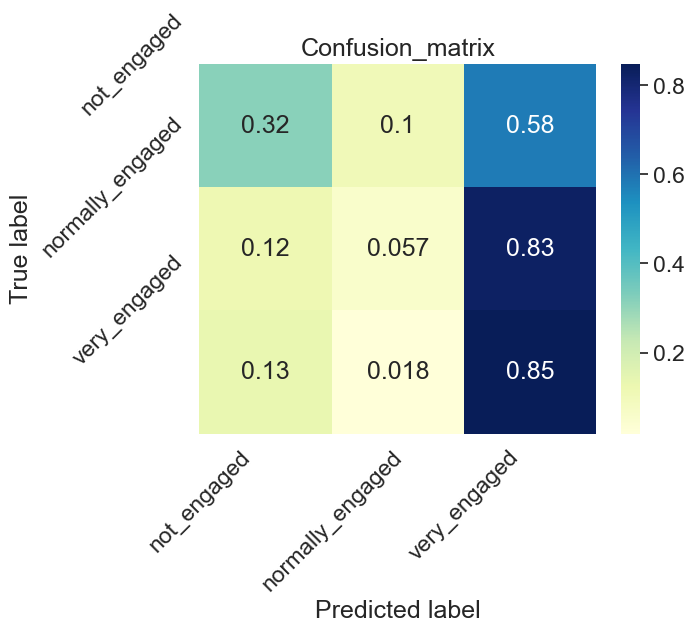

42/42 [==============================] - 0s 1ms/step
|stackedLSTM|
 Error rate = 0.5986394557823129 
 MSE =  1.090702947845805 
 Accuracy =  0.4013605442176871


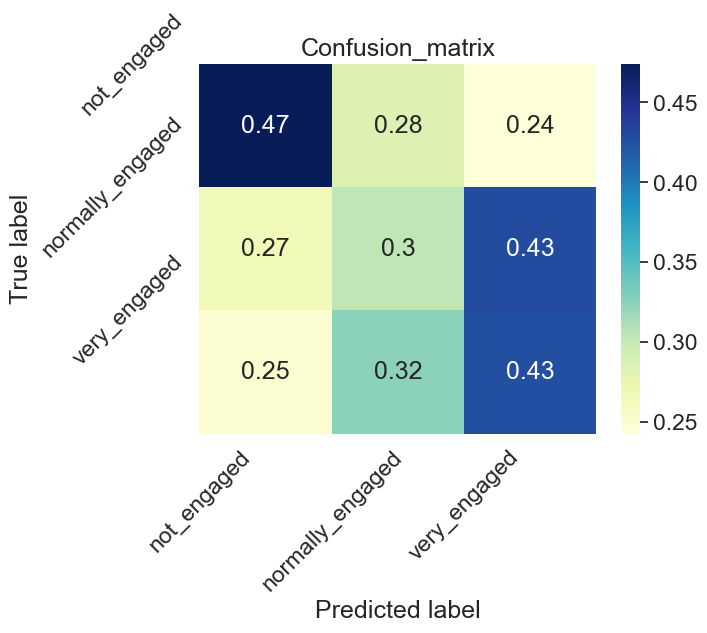

42/42 [==============================] - 0s 1ms/step
|biLSTM|
 Error rate = 0.6409674981103552 
 MSE =  1.5411942554799698 
 Accuracy =  0.35903250188964475


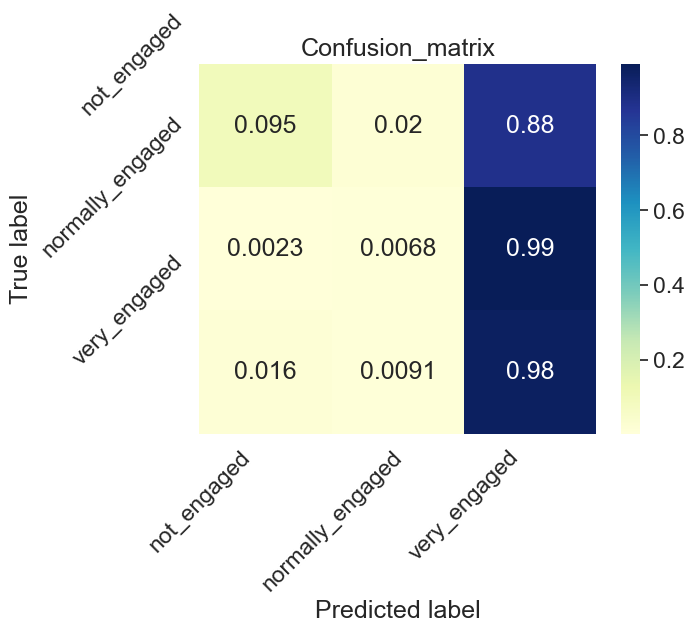

42/42 [==============================] - 0s 2ms/step
|bilstm_en|
 Error rate = 0.562358276643991 
 MSE =  0.8775510204081632 
 Accuracy =  0.4376417233560091


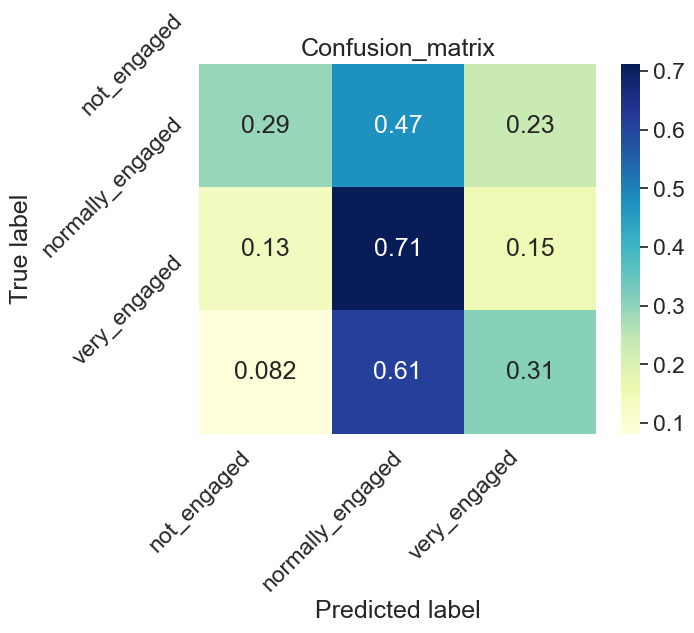

In [33]:
plot_conf_matrix(vanilaLSTM_model)
plot_conf_matrix(stackedLSTM_model)
plot_conf_matrix(biLSTM_model)
plot_conf_matrix(bilstm_en_model)

# [Case 2] Prepare non-averaged data input

In [17]:
# path = ('.../Documents/Dataset/DAiSEE/OpenFace_2.2.0_win_x64/processed/csv/')

def load_all_data(datapath,labelfile):
    #load label
    df = pd.read_csv(labelfile)
    
    #create empty list
    data_list = []
    label_list = []
    
    for noid, clipid in enumerate(df.New_ClipID):
        temp_df = pd.read_csv(datapath+clipid, nrows=300) #read csv files (n timestamps)
        # temp_df = temp_df.drop(temp_df.columns[0:5], axis=1) #drop first 5 columns 
        # temp_df = temp_df.iloc[9:300:21,:] #take 1 every 21 frame   
        temp_df = temp_df.groupby(np.arange(len(temp_df))//30).mean() #average every 30 frames, resulting 10 timesteps

        # ensure all data is float
        temp_df = temp_df.astype('float32')
              
        # PCA decomposition. Set components number from 329(original) to 200
        #     pca = decomposition.PCA(n_components=250)
        #     temp_df = pca.fit_transform(temp_df)
        #     print(temp_df)
        
        temp_df = np.array(temp_df, dtype=object)
        labl = df.Engagement[noid]
        labl = np.array(labl)
        #     print(temp_df,labl)
        data_list.append(temp_df)
        label_list.append(labl)    
#         break
    
    X = np.array(data_list, dtype=object) #features
    Y = np.array(label_list) #labels
    print('X shape:{} | Y shape:{}'.format(X.shape, Y.shape))
    
    return X, Y